# Machine Learning Classification Project  - Catastrophe Survival

The objective of this project is to develope a binary classification model that predicts wheather a passenger on the Titanic's final journey survived or not. I developed the model in one of my machine learning class at the University of Michigan.  

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import warnings 
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone

# Data Exploration

In [3]:
# Reading in data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
train.shape

(891, 12)

In [6]:
# Displaying dataframe column data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
# Genreating overall statistics of the data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
# Displaying null values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Variable Analysis

The visualizations are displaying the distribution of data in each column as well as showing the relationship between survival and other features. 

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

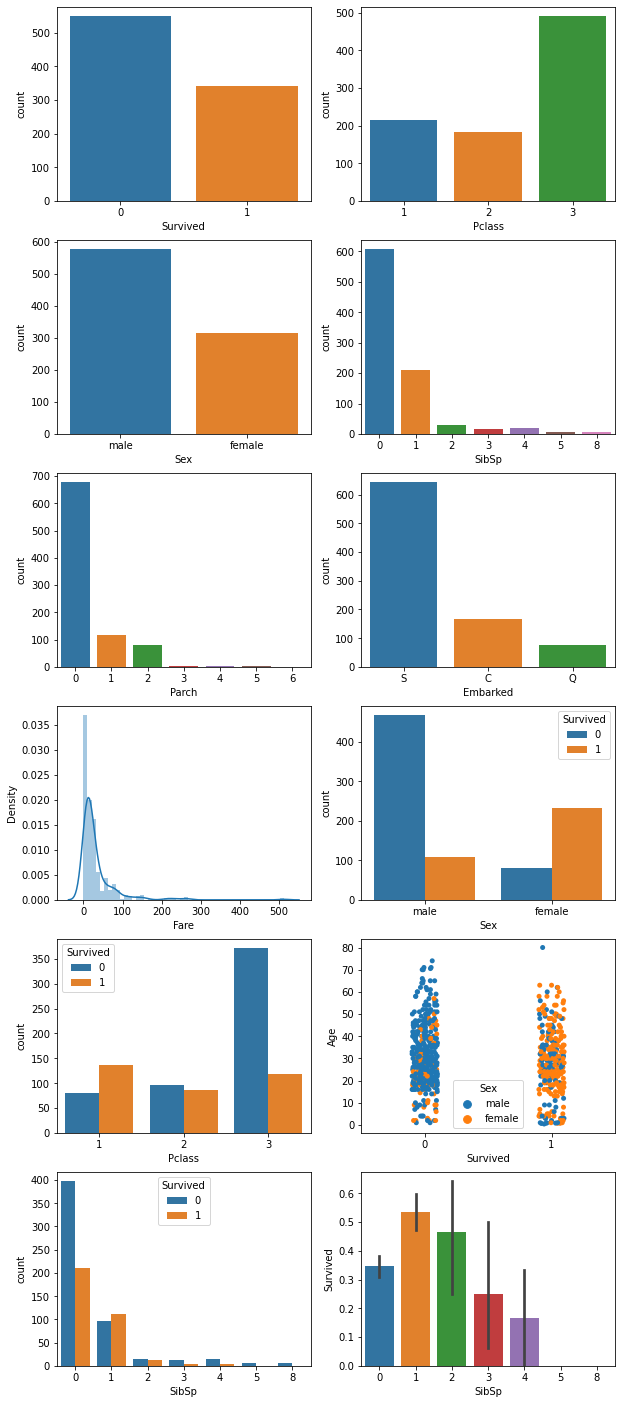

In [9]:
fig, ax = plt.subplots(6, 2, figsize = (10, 25))
sns.countplot('Survived', data = train, ax = ax[0][0])
sns.countplot('Pclass', data = train, ax = ax[0][1])
sns.countplot('Sex', data = train, ax = ax[1][0])
sns.countplot('SibSp', data = train, ax = ax[1][1])
sns.countplot('Parch', data = train, ax = ax[2][0])
sns.countplot('Embarked', data = train, ax = ax[2][1])
sns.distplot(train['Fare'], ax = ax[3][0])
sns.countplot('Sex', hue = 'Survived', data = train, ax = ax[3][1])
sns.countplot('Pclass', data = train, hue = 'Survived', ax = ax[4][0])
sns.stripplot(x = 'Survived', y = 'Age', data = train, hue = 'Sex', jitter = True, ax = ax[4][1])
sns.countplot('SibSp', data = train, hue = 'Survived', ax = ax[5][0])
sns.barplot('SibSp', 'Survived', data = train, ax = ax[5][1])


# Data Preparation

Below, I perform data preparation and feature engineering in order to fit the data to models and get more precise prediction results.

In [10]:
# Defining function for cleaning Ticket column
def ticket(tik):
    if ' ' in tik:
        return tik.split()[1]
    else:
        return tik

In [11]:
# Defining function for data cleaning
def DataTransform(df):
    df['Title'] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Mrs/Miss')
    df['Title'] = df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military')
    df['Ticket_Count'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Family'] = df.SibSp + df.Parch
    df = df.drop(columns = ['Name'])
    df = df.drop(columns = ['Cabin'])
    df = df.drop(columns = ['PassengerId'])
    df = df.drop(columns = ['Ticket'])
    
    return df

In [12]:
# Cleaning the intial dataset with function defined above
train = DataTransform(train)

# Building Pipeline

The next step is developing prediction model and training the model with training dataset.

In [13]:
# Splitting features and label columns
train_X = train.drop('Survived', axis = 1)
train_y = train['Survived'].copy()

In [14]:
# Creating data transformation pipeline for numerical columns
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])

In [15]:
# Creating data transformation pipeline for categorical columns
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('hotencoder', OneHotEncoder()),
    ])

In [16]:
# Creating data transformation pipeline for whole dataframe
from sklearn.compose import ColumnTransformer

num_attribs = list(train_X.select_dtypes(include=[np.number]))
cat_attribs = list(train_X.select_dtypes(exclude=[np.number]))

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs)
    ])

In [17]:
# Transforming data using the full pipeline
train_X_prepared = full_pipeline.fit_transform(train_X)

In [18]:
# Defining classification models
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    ]

In [19]:
# Fitting models to training data
for name, clf in zip(names, classifiers):
    clf.fit(train_X_prepared, train_y)
    y_predict = clf.predict(train_X_prepared)
    
    # Evaluating predictions
    accuracy = clf.score(train_X_prepared, train_y)
    print("%s Accuracy: %.2f%%" % (name,accuracy * 100.0))

Nearest Neighbors Accuracy: 87.21%
Linear SVM Accuracy: 80.47%
RBF SVM Accuracy: 90.35%
Gaussian Process Accuracy: 84.96%
Decision Tree Accuracy: 85.52%
Random Forest Accuracy: 84.29%
Neural Net Accuracy: 84.96%
AdaBoost Accuracy: 84.06%
Naive Bayes Accuracy: 81.37%


## Testing

The final step is to predict the survivals of test dataset, using the trained model. 

In [20]:
# Cleaning and transforming test data
test_transformed = DataTransform(test)
test_prepared = full_pipeline.transform(test_transformed)

In [21]:
# Creating voting classifier through combining all classification models
estimators = [(name, clf) for name, clf in zip(names, classifiers)]

eclf = VotingClassifier(estimators = estimators, voting = 'hard')
eclf = eclf.fit(train_X_prepared, train_y)

In [22]:
# Predicting on test data
predictions = eclf.predict(test_prepared)

In [23]:
dicti = {'PassengerId':list(test.PassengerId), 'Survived':list(predictions)}

In [24]:
prediction_data = pd.DataFrame(dicti)

In [25]:
prediction_data

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [26]:
prediction_data.to_csv('predictions.csv', index = False)

Since I developed the model for a Kaggle competition, the labels of testing set were not provided. However, my final model predicted the survival of passanges with an accuracy of 88%. 